In [15]:
%%capture

import pandas as pd
import numpy as np
# !pip install 'ray[tune]'
# !pip install wandb
# !wandb login
seed = 42

In [4]:
ellipse_df = pd.read_csv("../data/ELLIPSE_Full_manual_clean_finished_calculated.csv")

ellipse_df

,text_id,full_text,gender,grade,race_ethnicity,num_words,num_words2,num_words3,num_sent,num_para,...,task,SES,prompt,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions
0,2021000501,"Dear, TEACHER_NAME\n\nI think phone policy at ...",Male,8,Hispanic/Latino,111,122,118,7,2,...,Independent,Economically disadvantaged,Cell phones at school,3.0,3.5,2.5,3.5,3.0,3.5,2.5
1,2021000535,"Dear, Principal\r\n\r\nIn my opinion, I think ...",Female,8,Hispanic/Latino,99,105,102,6,2,...,Independent,Economically disadvantaged,Cell phones at school,3.0,2.5,3.0,4.0,3.5,3.0,3.5
2,2021000667,PHONES\n\nDear principal students should have ...,Female,8,Hispanic/Latino,121,134,128,4,2,...,Independent,Economically disadvantaged,Cell phones at school,3.0,2.5,3.0,3.0,3.0,3.5,3.0
3,2021000683,phones\n\ni think phones should be allowed in ...,Male,8,Hispanic/Latino,182,202,192,2,2,...,Independent,Economically disadvantaged,Cell phones at school,3.0,2.0,2.5,3.0,3.0,3.0,2.5
4,2021000705,Do you really think students need cell phones ...,Female,8,Hispanic/Latino,192,210,201,11,4,...,Independent,Not economically disadvantaged,Cell phones at school,3.0,2.0,3.0,3.0,3.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6477,AAAXMP138200002211022133_OR,The decision regarding extracurricular involve...,Male,12,Hispanic/Latino,348,369,368,17,5,...,Independent,Economically disadvantaged,Controlling extracurricular involvement,4.0,4.0,4.0,3.5,4.0,4.0,4.5
6478,AAAXMP138200002211062115_OR,"The school plans to change to a new, healthier...",Male,12,Asian/Pacific Islander,423,470,458,15,7,...,Independent,Economically disadvantaged,Lunch menus,3.5,3.5,3.0,3.5,3.0,3.5,3.5
6479,AAAXMP138200002211752151_OR,I raised by my grandparents and they always to...,Female,12,Asian/Pacific Islander,482,520,510,28,5,...,Independent,Not economically disadvantaged,Curfews for teenagers,4.0,4.0,3.0,4.0,4.0,3.0,4.0
6480,AAAXMP138200002214212144_OR,Imagine the world if students didn't complete ...,Female,12,Asian/Pacific Islander,758,860,835,50,6,...,Independent,Economically disadvantaged,Summer projects,3.5,3.5,3.5,4.0,4.0,3.0,3.0


In [5]:
df = ellipse_df[['full_text', 'Syntax']]
df.columns = ['text', 'labels']
df['text'] = df['text'].apply(lambda x: x.strip())

/tmp/ipykernel_3537/752900168.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: x.strip())


## Build Dataset

In [6]:
from datasets import load_dataset, load_metric, Dataset, Value, ClassLabel, Features, DatasetDict

In [7]:
def buildDataset(df):
    full_dataset = Dataset.from_pandas(df, preserve_index=False)
    # 70% train, 30% test
    train_test = full_dataset.train_test_split(test_size=0.3, seed=seed)
    test_valid = train_test['test'].train_test_split(test_size=0.5, seed=seed)
    # gather everyone if you want to have a single DatasetDict
    final_dataset = DatasetDict({
        'train': train_test['train'],
        'valid': test_valid['test'], 
        'test': test_valid['test']})
    return final_dataset

In [8]:
ds = buildDataset(df)
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 4537
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 973
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 973
    })
})

In [9]:
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments, EarlyStoppingCallback
from transformers import LongformerTokenizer, LongformerForSequenceClassification, LongformerConfig

import torch
model_name =  'allenai/longformer-base-4096'
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")

torch.cuda.empty_cache()

In [10]:
tokenizer = LongformerTokenizer.from_pretrained(model_name)

def tokenize_inputs(example):
    return tokenizer(example['text'], max_length=2048, truncation=True)

ds_t = ds.map(tokenize_inputs, batched=True)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr 

def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    mse = mean_squared_error(labels, logits)
    rmse = mean_squared_error(labels, logits, squared=False)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)

    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "smape": smape}

In [12]:
learning_rate = 1e-05
batch_size = 16
seed = 42
num_epochs = 4

def model_init():
    return LongformerForSequenceClassification.from_pretrained(model_name, num_labels=1).to(device)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [13]:
# trainer = Trainer(
#     model_init=model_init,
# )

training_args = TrainingArguments(
    output_dir = 'syntax_checkpoints',
    optim = 'adamw_torch',
    num_train_epochs = num_epochs,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    gradient_accumulation_steps=4, 
    gradient_checkpointing=True,
    weight_decay = 0.01,
    learning_rate = learning_rate,
    logging_dir = f'./logs/content',
    save_total_limit = 10,
    load_best_model_at_end = True,
    metric_for_best_model = 'mse',
    evaluation_strategy = "epoch",
    save_strategy = "epoch", 
    greater_is_better = False,
    seed=seed,
    log_level = 'error',  # took me ages to find these options
    disable_tqdm = False, # enable output cell scrolling in JupyterLab for even more beautiful output :D
) 

    # Call the Trainer
trainer = Trainer(
    model_init = model_init,
    args = training_args,
    data_collator=data_collator,
    train_dataset = ds_t['train'],
    eval_dataset = ds_t['valid'],
    compute_metrics = compute_metrics_for_regression,
    #callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: tiedaar. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Mse,Rmse,Mae,R2,Smape
1,No log,0.282555,0.282555,0.531559,0.423868,0.356744,23057.712230
2,No log,0.334046,0.334046,0.577967,0.467701,0.239522,22850.443988
3,No log,0.376912,0.376912,0.613931,0.495553,0.141934,24657.253854
4,No log,0.357522,0.357522,0.597932,0.482435,0.186075,24171.689620


TrainOutput(global_step=284, training_loss=0.5554050929109815, metrics={'train_runtime': 3755.9898, 'train_samples_per_second': 4.832, 'train_steps_per_second': 0.076, 'total_flos': 1.1167196968195386e+16, 'train_loss': 0.5554050929109815, 'epoch': 4.0})

PearsonRResult(statistic=array([0.6878245716116334], dtype=object), pvalue=2.9391969288064505e-137)


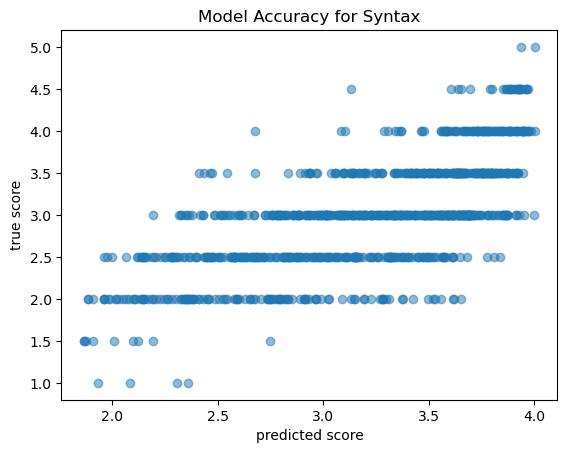

In [19]:
import scipy
preds, labs, metrics = trainer.predict(ds_t['test'])
print(scipy.stats.pearsonr(labs, preds))

from matplotlib import pyplot as plt
preds.flatten()
plt.scatter(preds, labs, alpha=0.5)
plt.ylabel('true score')
plt.xlabel('predicted score')
plt.title('Model Accuracy for Syntax')
plt.show()

In [18]:
trainer.save_model('../bin/syntax_model')

In [ ]:
def model_init():
    return LongformerForSequenceClassification.from_pretrained(model_name, num_labels=1, return_dict=True).to(device)

training_args = TrainingArguments(
    "test", 
    evaluation_strategy="epoch", 
    disable_tqdm=True,
    gradient_accumulation_steps=4, 
    gradient_checkpointing=True,
    report_to="wandb",)

trainer = Trainer(
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=ds_t["train"],
    eval_dataset=ds_t["valid"],
    model_init=model_init,
    compute_metrics=compute_metrics_for_regression,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),    
)

trainer.train()

trainer.hyperparameter_search(
    direction="minimize", 
    backend="ray", 
    n_trials=10, # number of trials

)